In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
inspector = inspect(engine)

In [7]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [11]:
#use inspector to understand column names and data types
idata = inspector.get_columns('measurement')
for column in idata:
    print (column['name'], column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
idata2 = inspector.get_columns('station')
for column in idata2:
    print (column['name'], column['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results


In [14]:
# Calculate the date 1 year ago from the last data point in the database
enddate = session.query(Measurement.date).\
    order_by(Measurement.date.desc()).first()

enddate

('2017-08-23')

In [15]:
# Perform a query to retrieve the data and precipitation scores
yearsdata = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > '2016-08-23',).\
    order_by(Measurement.date.desc()).all()

In [16]:
#get date/precip
date1 = [result[0] for result in yearsdata]
percip = [result[1] for result in yearsdata]

In [17]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
#create DF with data
PDict = {
    "Date":date1,
    "Perciptitation":percip
}

PerDF = pd.DataFrame(PDict)

#groupby for clarity

PerDF = PerDF.groupby('Date').sum()
PerDF = PerDF.sort_values(by='Date', ascending = True)
PerDF.head()
                          

,Perciptitation
Date,
2016-08-24,9.33
2016-08-25,0.54
2016-08-26,0.10
2016-08-27,0.32
2016-08-28,3.10


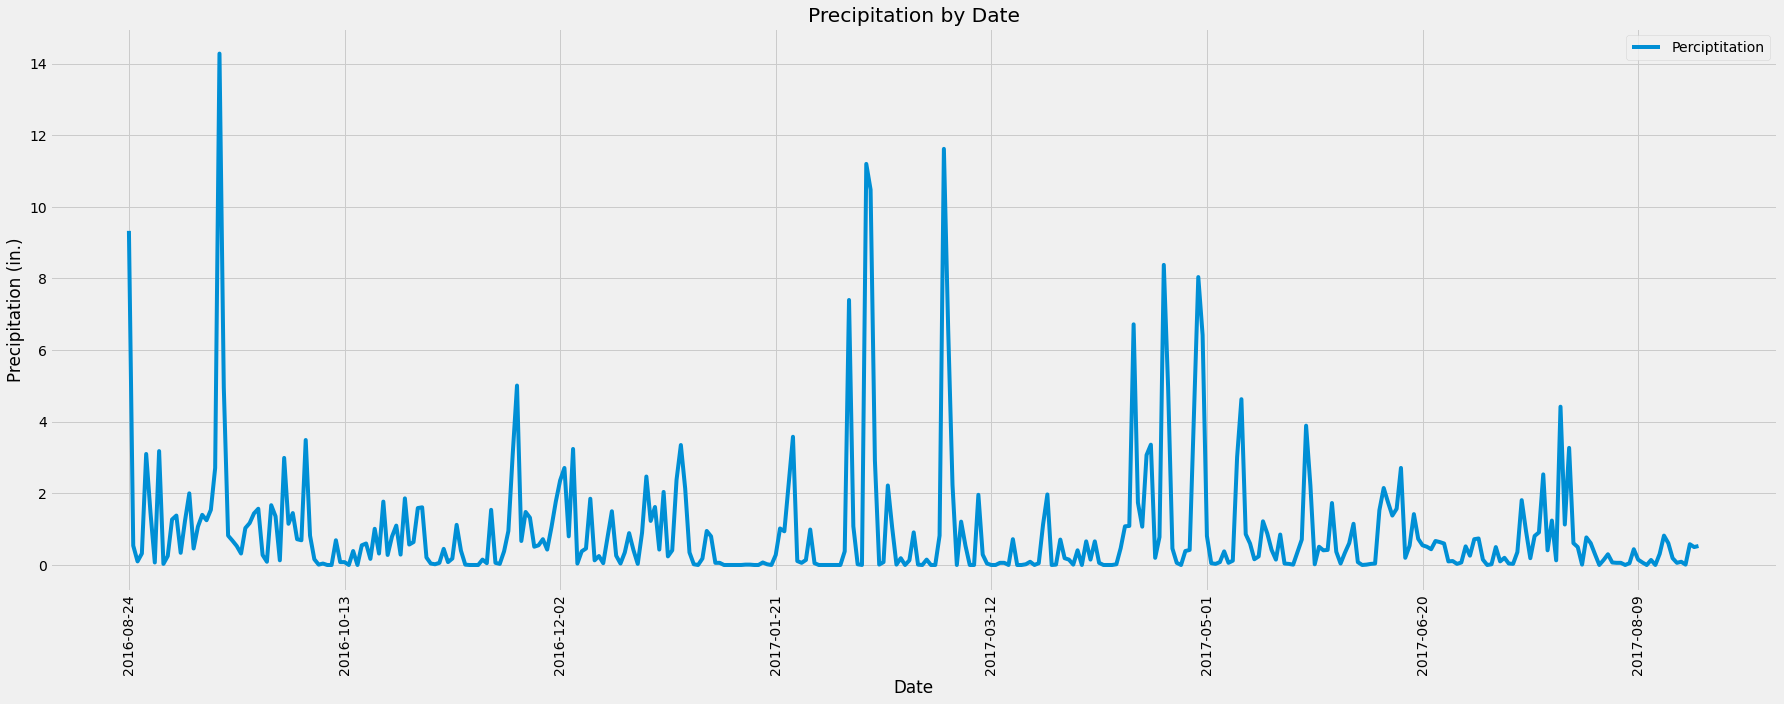

In [18]:
# Use Pandas Plotting with Matplotlib to plot the data
PerDF.plot(figsize=(25,10), rot=90)
plt.xticks(rotation="vertical")
plt.title("Precipitation by Date")
plt.ylabel("Precipitation (in.)")
plt.xlabel("Date")
plt.tight_layout()
plt.show()

In [19]:
# Use Pandas to calcualte the summary statistics for the precipitation data
PerDF.describe()

,Perciptitation
count,365.000000
mean,0.974164
std,1.776466
min,0.000000
25%,0.050000
50%,0.400000
75%,1.080000
max,14.280000


In [20]:
# Design a query to show how many stations are available in this dataset?
session.query(Station.id).count()

9

In [21]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
astation = session.query(Measurement.station, func.count(Measurement.date)).\
    group_by(Measurement.station).order_by(func.count(Measurement.date).desc()).all()

astation

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

select = [Measurement.station,
          func.min(Measurement.tobs),
          func.max(Measurement.tobs),
          func.avg(Measurement.tobs),]

tdata = session.query(*select).\
    filter(Measurement.station == 'USC00519281').all()

tdata
#Station, Min Temp, Max Temp, Average Temp

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

In [23]:
# Choose the station with the highest number of temperature observations.
ATstation = session.query(Measurement.station, func.count(Measurement.tobs)).\
    group_by(Measurement.station).order_by(func.count(Measurement.date).desc()).all()

ATstation

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [24]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
bstation = 'USC00519281'

# busy_year = session.query(measurement.tobs).\
#     filter(measurement.date > '2016-08-23', measurement.station == busy_station).\
#     order_by(measurement.date.desc()).all()


tstation = session.query(Measurement.tobs).\
    filter(Measurement.date > '2016-08-23', Measurement.station == bstation).\
    order_by(Measurement.date.desc()).all()


In [25]:
#grabdata
TobsD = [result[0] for result in tstation]

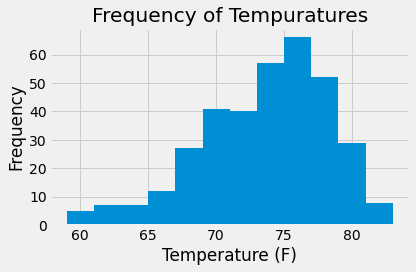

In [26]:
#plot
plt.hist(TobsD, bins = 12)
plt.title("Frequency of Tempuratures")
plt.xlabel('Temperature (F)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

## Bonus Challenge Assignment

In [27]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [28]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [29]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [30]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [31]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [32]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [33]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [34]:
# Plot the daily normals as an area plot with `stacked=False`
